In [ ]:
# written by evan groover, 2025

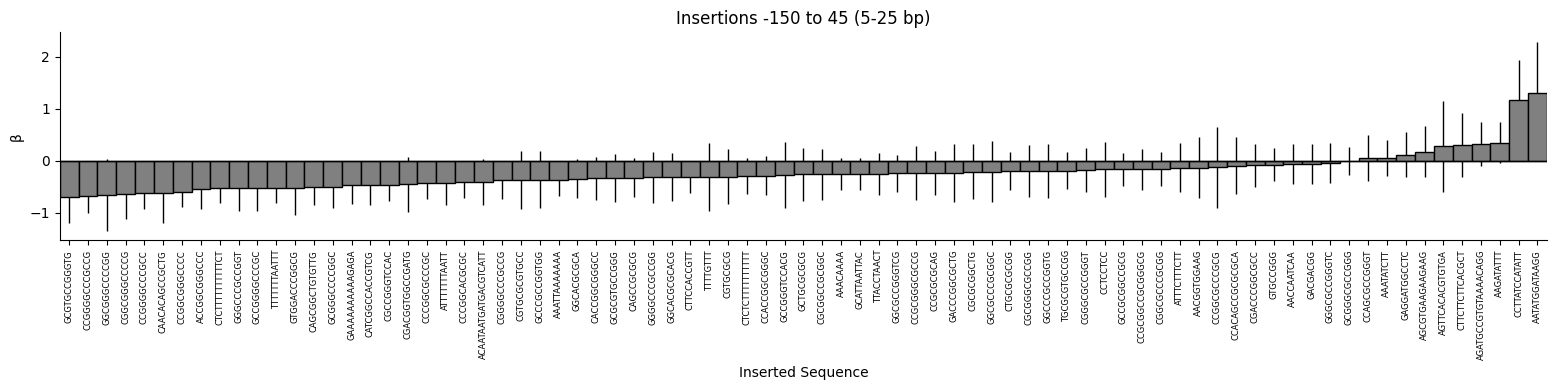

In [1]:
# Figure 4B: Average Motif Enrichment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# SETUP
file_path = '.../3C_log2.csv'
region_start, region_end = -150, 45

# SET LENGTH AND No. OF OCCURENCES TO FILTER FOR DESIGNED INSERTS
min_len, max_len = 5, 25
min_insertions = 10

bar_color = 'gray'
edge_color = 'black'
line_width = 1
error_color = 'black'


df = pd.read_csv(file_path)
df = df[df['mut_in_prom_utr'] == True].copy()


pattern_ins = re.compile(r'I(-?\d+)([ACGT]+)$')
parsed = []
for mut, beta in zip(df['mut'], df['beta']):
    m = pattern_ins.match(str(mut))
    if m:
        pos, seq = int(m.group(1)), m.group(2)
        if region_start <= pos <= region_end and min_len <= len(seq) <= max_len:
            parsed.append((seq, beta))

df_ins = pd.DataFrame(parsed, columns=['seq', 'beta'])


counts = df_ins['seq'].value_counts()
valid_seqs = counts[counts >= min_insertions].index
df_filtered = df_ins[df_ins['seq'].isin(valid_seqs)].copy()


group_stats = df_filtered.groupby('seq')['beta'].agg(['mean', 'std'])
group_stats = group_stats.sort_values(by='mean')

# PLOT
x = np.arange(len(group_stats)) + 1
fig, ax = plt.subplots(figsize=(0.2 * len(group_stats), 4))

ax.bar(
    x,
    group_stats['mean'],
    color=bar_color,
    edgecolor=edge_color,
    linewidth=line_width,
    width=1
)

# WHISKERS
for xi, mean, std in zip(x, group_stats['mean'], group_stats['std']):
    ax.errorbar(
        xi,
        mean,
        yerr=std,
        fmt='none',
        ecolor=error_color,
        elinewidth=line_width,
        capsize=0,
        zorder=0
    )

# FORMAT
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(group_stats.index, rotation=90, fontsize=6)
ax.set_xlim(0.5, len(x) + 0.5)
ax.set_ylabel('β')
ax.set_xlabel('Inserted Sequence')
ax.set_title(f'Insertions {region_start} to {region_end} ({min_len}-{max_len} bp)')

# PLOT
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig("3C_insertions_barchart_sorted.pdf", bbox_inches='tight')
plt.show()


/var/folders/pj/6dp7pxss7hv_4mqplr2ztt0r0000gn/T/ipykernel_66913/2255795425.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


▶ saved to insertion_motif_heatmap_shorted3CALL.pdf


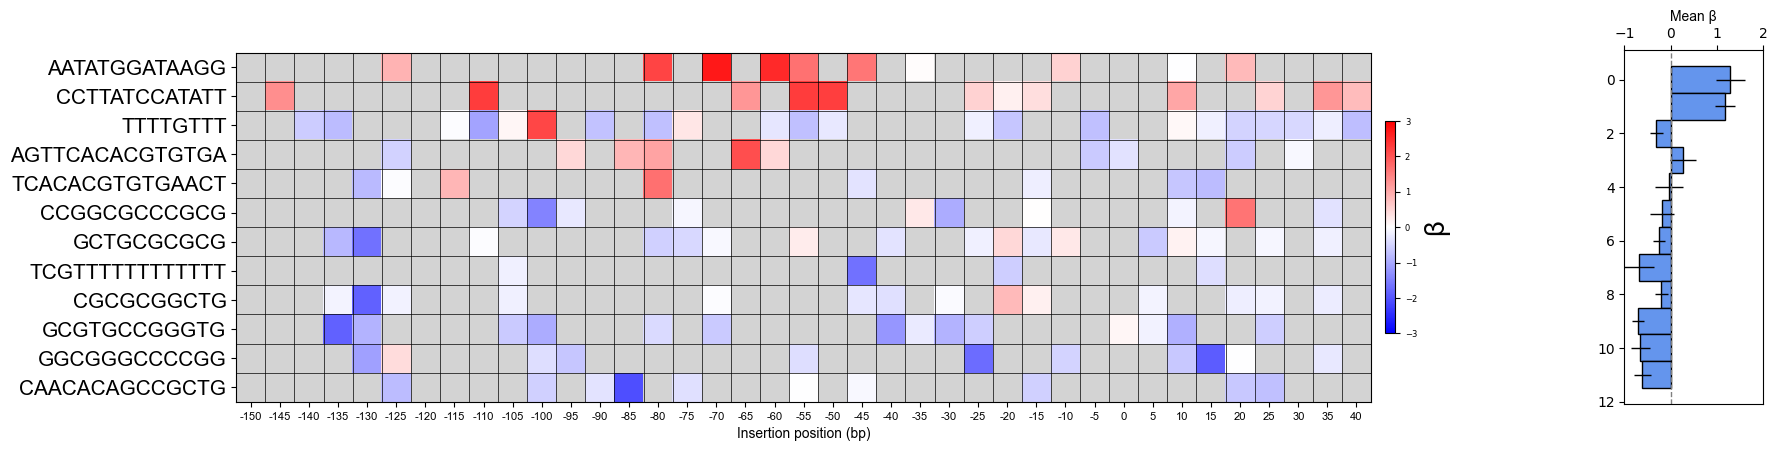

In [2]:
# FIGURE 4C: TOP AND BOTTOM MOTIFS

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

# CONFIGURE

CSV_FILE         = '.../3C_log2.csv'
X_MIN, X_MAX, X_STEP  = -150, 45, 5
MIN_LEN, MAX_LEN      = 3, 100
MIN_MOTIF_COUNT       = 5       # if toggled, sets upper bound on number of times a motif can occur in given range
MAX_MOTIF_COUNT       = None    # if toggled, sets upper bound on number of times a motif can occur in given range
MAX_HOMOPOLYMER       = None    # if toggled, removes homopolymers (for analysis only)
MAX_CG_REPEAT         = None    # if toggled, removes CG repeat-rich sequences (for analysis only)

BETA_VMIN, BETA_VMAX  = -3, 3
OUT_PDF               = 'insertion_motif_heatmap_shorted3CALL.pdf'

# SHORTENING LIST
COMBINE_REVCOMPS = False   # can be used to consolidate reverse compliments (for analysis only)
SHORTEN_LIST  = True      # if True, only show top+bottom groups
TOP_K         =    6     # how many top motif‐groups to show
BOTTOM_K      =   6      # how many bottom motif‐groups to show

# PLOTTING AND ANALYSIS
_rc_map = str.maketrans("ACGT","TGCA")
def revcomp(s): return s.translate(_rc_map)[::-1]

def longest_homopolymer(s):
    runs = re.findall(r'(A+|C+|G+|T+)', s)
    return max((len(r) for r in runs), default=0)

def longest_cg_repeat(s):
    runs = re.findall(r'((?:CG)+)', s)
    if not runs:
        return 0
    # each 'CGCG' => 2 repeats, so len(run)/2
    return max(len(r)//2 for r in runs)

# LOAD AND FILTER
df = pd.read_csv(CSV_FILE)
df = df[df['mut_in_prom_utr']==True]

pat_ins = re.compile(r'^I(-?\d+)([ACGT]+)$')
records = []
for mut, beta in zip(df['mut'], df['beta']):
    m = pat_ins.match(mut)
    if not m:
        continue
    pos, seq = int(m.group(1)), m.group(2)
    if MIN_LEN <= len(seq) <= MAX_LEN:
        records.append({'motif': seq, 'pos': pos, 'beta': float(beta)})

df_ins = pd.DataFrame(records)
if df_ins.empty:
    raise RuntimeError("No insertions of length in range.")

vc = df_ins['motif'].value_counts()
valid = vc[vc >= MIN_MOTIF_COUNT].index
if MAX_MOTIF_COUNT is not None:
    valid = valid.intersection(vc[vc <= MAX_MOTIF_COUNT].index)

def is_too_repetitive(seq):
    if MAX_HOMOPOLYMER is not None and longest_homopolymer(seq) > MAX_HOMOPOLYMER:
        return True
    if MAX_CG_REPEAT is not None and longest_cg_repeat(seq) > MAX_CG_REPEAT:
        return True
    return False

valid = [m for m in valid if not is_too_repetitive(m)]

df_ins = df_ins[df_ins['motif'].isin(valid)].copy()
if df_ins.empty:
    raise RuntimeError("No motifs survive count/repetition filters.")

grid = set(range(X_MIN, X_MAX+0, X_STEP))
occupied = set()
def assign_bin(p):
    if p in grid:
        occupied.add(p); return p
    n = X_STEP * round(p/X_STEP)
    if abs(p-n)<=0 and n in grid and n not in occupied:
        occupied.add(n); return n
    return np.nan

df_ins['pos_bin'] = df_ins['pos'].apply(assign_bin).astype('Int64')
df_ins.dropna(subset=['pos_bin'], inplace=True)

df_ins['absβ'] = df_ins['beta'].abs()
df_ins.sort_values('absβ', ascending=False, inplace=True)
df_ins.drop_duplicates(['motif','pos_bin'], inplace=True)
df_ins.drop(columns='absβ', inplace=True)

stats = df_ins.groupby('motif')['beta'].agg(['mean','std','count'])
stats['sem'] = stats['std']/np.sqrt(stats['count'])
stats.sort_values('mean', ascending=False, inplace=True)
rep_motifs = stats.index.tolist()

positions = sorted(df_ins['pos_bin'].unique())
n_pos = len(positions)
raw_heat = np.full((len(rep_motifs), n_pos), np.nan)
for i, motif in enumerate(rep_motifs):
    sub = df_ins[df_ins['motif']==motif].set_index('pos_bin')
    for j, p in enumerate(positions):
        if p in sub.index:
            raw_heat[i,j] = sub.loc[p,'beta']

# COLLAPSE RCs

if COMBINE_REVCOMPS:
    seen = set()
    filtered = []
    for m in rep_motifs:
        if m in seen:
            continue
        rc = revcomp(m)
        if rc in stats.index and rc not in seen and rc != m:
            # choose whichever orientation has the larger mean β
            chosen = m if stats.at[m, 'mean'] >= stats.at[rc, 'mean'] else rc
            filtered.append(chosen)
            seen.update([m, rc])
        else:
            filtered.append(m)
            seen.add(m)
    new_order = filtered
else:
    new_order = rep_motifs             


heat  = raw_heat[[rep_motifs.index(m) for m in new_order], :]
stats = stats.reindex(new_order)

df_rank = df_ins[df_ins['motif'].isin(new_order)]

extremes = df_rank.groupby('motif')['beta'].agg(
    max_beta='max',
    min_beta='min'
)

extremes['extreme'] = extremes.apply(
    lambda r: r['max_beta'] if abs(r['max_beta']) >= abs(r['min_beta']) else r['min_beta'],
    axis=1
)

full_order = (
    extremes.sort_values('extreme', ascending=False)
            .index
            .tolist()
)

if SHORTEN_LIST:
    top_motifs = full_order[:TOP_K]
    bot_motifs = full_order[-BOTTOM_K:] if BOTTOM_K > 0 else []
    final_order = top_motifs + bot_motifs
else:
    final_order = full_order


heat  = heat[[new_order.index(m) for m in final_order], :]
stats = stats.loc[final_order]
new_order = final_order          # <- drives y-labels later
n_m = len(new_order)             # <- keeps figure height correct


# PLOTTING
cmap = LinearSegmentedColormap.from_list('bwr',['blue','white','red'])
norm = Normalize(vmin=BETA_VMIN, vmax=BETA_VMAX)

cell = 0.3
fig_h = cell*n_m + 1.0
fig_w = cell*n_pos + 8.0
fig = plt.figure(figsize=(fig_w, fig_h))
gs  = fig.add_gridspec(1,2, width_ratios=[n_pos,4], wspace=0.05)
ax_hm = fig.add_subplot(gs[0,0])
ax_bar= fig.add_subplot(gs[0,1])


im = ax_hm.imshow(
    np.ma.masked_where(np.isnan(heat), heat),
    aspect='equal', origin='upper',
    cmap=cmap, norm=norm, interpolation='none'
)

ax_hm.set_xticks(np.arange(-.5,n_pos,1), minor=True)
ax_hm.set_yticks(np.arange(-.5,n_m,1), minor=True)
ax_hm.grid(which='minor', color='black', lw=0.5)
ax_hm.tick_params(which='minor', bottom=False, left=False)

ax_hm.set_yticks(np.arange(n_m))
ax_hm.set_yticklabels(new_order, fontsize=15, fontname='Arial')
ax_hm.set_xticks(np.arange(n_pos))
ax_hm.set_xticklabels(positions, fontsize=8, fontname='Arial')
ax_hm.set_xlabel('Insertion position (bp)', fontname='Arial')

ypos = np.arange(n_m)
ax_bar.barh(
    ypos, stats['mean'], xerr=stats['sem'], height=1.0,
    align='center', facecolor='cornflowerblue',
    edgecolor='black', lw=1,
    error_kw={'capsize':0,'elinewidth':1}
)
ax_bar.axvline(0, color='gray', ls='--', lw=1)
ax_bar.set_xlim(-1, 2)
ax_bar.set_xlabel('Mean β', fontname='Arial')
ax_bar.invert_yaxis()
ax_bar.xaxis.set_label_position('top')
ax_bar.xaxis.set_ticks_position('top')

cbar = fig.colorbar(im, ax=ax_hm, orientation='vertical', pad=0.01, shrink=0.6)
cbar.set_label('β', fontname='Arial', fontsize=20)
cbar.ax.tick_params(labelsize=6)


ax_hm.set_facecolor('lightgray')
ax_bar.set_facecolor('none')
fig.patch.set_facecolor('white')

plt.tight_layout()
fig.savefig(OUT_PDF, dpi=400)
print("▶ saved to", OUT_PDF)
plt.show()

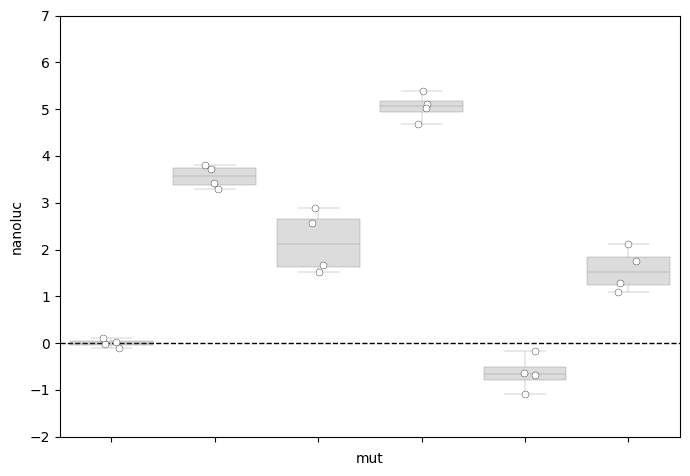

In [7]:
# FIGURE 4E: nanoluc boxplot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '.../nanoluc.csv'
ymin, ymax = -2, 7  

df = pd.read_csv(file_path)


plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=df, x='mut', y='nanoluc',
                 color='gainsboro', width=0.8, linewidth=0.25, fliersize=0)
sns.stripplot(
    data=df, x='mut', y='nanoluc',
    size=5, jitter=True, alpha=1,
    marker='o', edgecolor='black', linewidth=0.25,
    color='white'  # fill color
)

ax.set_ylim(ymin, ymax)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.spines[['right', 'top']].set_visible(True)
plt.tight_layout()
ax.set_xticklabels([])

plt.savefig("output.pdf", bbox_inches='tight')
plt.show()
